In [ ]:
!pip install keras
!pip install tensorflow



In [ ]:
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!bash rapidsai-csp-utils/colab/rapids-colab.sh stable

import sys, os

dist_package_index = sys.path.index('/usr/local/lib/python3.6/dist-packages')
sys.path = sys.path[:dist_package_index] + ['/usr/local/lib/python3.6/site-packages'] + sys.path[dist_package_index:]
sys.path
exec(open('rapidsai-csp-utils/colab/update_modules.py').read(), globals())

In [3]:
!apt install libopenblas-base libomp-dev 

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libomp-dev is already the newest version (5.0.1-1).
libopenblas-base is already the newest version (0.2.20+ds-4).
0 upgraded, 0 newly installed, 0 to remove and 14 not upgraded.


In [4]:
import numpy as np
from sklearn.datasets import fetch_openml
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pickle
from cuml.manifold import TSNE



In [5]:
x, y = fetch_openml('mnist_784', version=1, return_X_y=True)
x = (x/255).astype('float32')

(70000,)

In [7]:
pca=PCA(0.90)       #Redcing dimensions such that 90% of variations is conserved
y = to_categorical(y)

pca.fit(x)
x=pca.transform(x)
print("n components",pca.n_components_)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=42)

n components 87


(10500, 87)

In [85]:
weight_cost_relu=[]
bias_relu=[]
weight_cost_sigmoid=[]
bias_sigmoid=[]
weight_cost_tanh=[]
bias_tanh=[]
weight_cost_linear=[]
bias_linear=[]

In [131]:
class MyNeuralNetwork:
    """
    My implementation of a Neural Network Classifier.
    """

    acti_fns = ['relu', 'sigmoid', 'linear', 'tanh', 'softmax']
    weight_inits = ['zero', 'random', 'normal']

    def __init__(self, n_layers, layer_sizes, activation, learning_rate, weight_init, batch_size, num_epochs):

        self.X_prev=[0]*(n_layers-1)  
        self.y_prev=[0]*(n_layers-1)

        self.n_layers=n_layers
        self.layer_sizes=layer_sizes
        self.activation=activation       #saving parameters
        self.learning_rate=learning_rate
        self.weight_init=weight_init
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        self.Layers=[]
        self.costs=[]
        self.test_cost=[]
        self.Bias=[]
        self.Z=[0]*(n_layers-1)
        
        if weight_init== "random":
            for i in range(n_layers-1):                                                      #initialising weights and bias
                self.Layers.append(self.random_init(   (self.layer_sizes[i],self.layer_sizes[i+1])   )   )
                self.Bias.append(np.zeros(self.layer_sizes[i+1]))
            for weight in range(n_layers-1):
                    bi=self.Bias[weight]
                    bi=[[bi[i]] for i in range(len(bi))]
                    self.Bias[weight]=bi

        if weight_init== "zero":
            for i in range(n_layers-1):
                self.Layers.append(self.zero_init(   (self.layer_sizes[i],self.layer_sizes[i+1])   )   )
                self.Bias.append(np.zeros(self.layer_sizes[i+1]))
            for weight in range(n_layers-1):
                    bi=self.Bias[weight]
                    bi=[[bi[i]] for i in range(len(bi))]
                    self.Bias[weight]=bi                

        if weight_init== "normal":
            for i in range(n_layers-1):
                self.Layers.append(self.normal_init(   (self.layer_sizes[i+1],self.layer_sizes[i])   )   )
                self.Bias.append(np.zeros(self.layer_sizes[i+1]))
            for weight in range(n_layers-1):
                    bi=self.Bias[weight]
                    bi=[[bi[i]] for i in range(len(bi))]
                    self.Bias[weight]=bi       



            
    def relu(self, X):
        X[X<=0]=0
                                      #relu
        return X

    def relu_grad(self, X):
        X[X>0]=1                      #reu_grad
        X[X<=0]=0.1

        return X

    def sigmoid(self, X):
        
        ex=np.exp(-1*X)
        den=1+ex                           #sigmoid
        x_calc=np.reciprocal(den)

        return x_calc

    def sigmoid_grad(self, X):

        x_calc=(1-self.sigmoid(X))*self.sigmoid(X)
                                                        #sigmoid_grad
        return x_calc

    def linear(self, X):
        return 1*X                       #linear
        

    def linear_grad(self, X):
      Xx= np.zeros(shape=X.shape)+1          #linear_grad
      return Xx

    def tanh(self, X):
        return np.tanh(X)
                                        #tanh and tanh_grad
    def tanh_grad(self, X):

        return 1 - np.square(np.tanh(X))

    def softmax(self, X):
        return np.exp(X) / np.sum(np.exp(X), axis=0)


    def softmax_grad(self, X):
        return self.softmax(X)/np.sum(self.softmax(X),axis=0) * (1-self.softmax(X)/np.sum(self.softmax(X),axis=0)) #softmax_grad
       

    def zero_init(self, shape):
        return np.zeros([shape[1], shape[0]])      #defining weights
        

        

    def random_init(self, shape):
        return np.random.randn(shape[1], shape[0])*0.01

        

    def normal_init(self, shape):
        
        return (np.random.normal(0,1,shape))*0.01


    def logloss(self,y, y_pred):
        n = y_pred.shape[0]	
        return (-np.sum(y * np.log(y_pred))) / n        #costfunction
        
  

    def d_logloss(self,y, y_pred):
        return y_pred - y   #cost derivative
     

    def feed_forward(self,X_prev,W,b,weight):

        self.Z[weight]=np.dot(W[weight], X_prev[weight]) +b[weight]
                                                                                  #feedforwarding
  
        if weight==3:
          X=self.softmax(self.Z[weight])
        else:

          if self.activation=='relu':
              X=self.relu(self.Z[weight])
          elif self.activation=='sigmoid':
              X=self.sigmoid(self.Z[weight])
          elif self.activation=='linear':
              X=self.linear(self.Z[weight])                #choosing activation
          elif self.activation=='tanh':
              X=self.tanh(self.Z[weight])
          elif self.activation=='softmax':
              X=self.softmax(self.Z[weight])


        
        return X


    def backpropogation(self,dX,X_prev,Layers,Bias,layer):
        #print(self.sigmoid_grad(self.Z[layer]).shape,dX.shape)
        if self.activation=='relu':
          dZ = np.multiply(self.relu_grad(self.Z[layer]) , dX)   
        elif self.activation=='sigmoid':
          dZ = np.multiply(self.sigmoid_grad(self.Z[layer]) , dX)
        elif self.activation=='linear':
          dZ = np.multiply(self.linear_grad(self.Z[layer]) , dX)            #backpropogation using required gradient
        elif self.activation=='tanh':
          dZ = np.multiply(self.tanh_grad(self.Z[layer]) , dX)
        elif self.activation=='softmax':
          dZ = np.multiply(self.softmax_grad(self.Z[layer]) , dX)
        
        dW = 1/dZ.shape[1] * np.dot(dZ, self.X_prev[layer].T)

        db = 1/dZ.shape[1] * np.sum(dZ, axis=1, keepdims=True)

        dX_prev = np.dot(self.Layers[layer].T, dZ)
        Layers[layer] = Layers[layer] - self.learning_rate * dW
        Bias[layer] = Bias[layer] - self.learning_rate * db

        return dX_prev
    
        


    def fit(self, X_train, y_train,X_test,y_test):

        XX_train= np.array_split(X_train,int(X_train.shape[0]//self.batch_size))
        yy_train=np.array_split(y_train,int(X_train.shape[0]//self.batch_size))
  
    
        for epochs in range(self.num_epochs):
             print(epochs)    
             for i in range(int(X_train.shape[0]//self.batch_size)):         
                X=XX_train[i].T                           #fitting our data
                y=yy_train[i]

                for weight in range(len(self.Layers)):
                   
                    self.X_prev[weight] = X 
                    X = self.feed_forward(self.X_prev,self.Layers,self.Bias,weight)
                    
                
                if i==int(X_train.shape[0]//self.batch_size)-1:      
                    cost = 1/X.shape[1] * np.sum(self.logloss(y.T, X))                 #storing cost at each iteration for train set
                    print(cost)
                    self.costs.append(cost)
            
                dX = self.d_logloss(y.T, X)
    
                for layer in reversed(range(len(self.Layers))):
                    dX = self.backpropogation(dX,self.X_prev,self.Layers,self.Bias,layer)  


                self.X_prev=[0]*(self.n_layers-1)            
                self.Z=[0]*(self.n_layers-1)

             Xt=X_test.T
            
             yt=y_test
             
             for weight in range(self.n_layers-1):
                    self.y_prev[weight] = Xt
                    Xt = self.feed_forward(self.y_prev,self.Layers,self.Bias,weight)       #storing cost at each iteration for validation set
            
            
             tc = 1/Xt.shape[1] * np.sum(self.logloss(yt.T, Xt))
             self.test_cost.append(tc)
        global weight_cost_relu   
        global bias_relu
        global weight_cost_sigmoid 
        global bias_sigmoid
        global weight_cost_tanh
        global bias_tanh
        global weight_cost_linear   
        global bias__linear
        if self.activation=="relu":
          weight_cost_relu=self.Layers         #saving weight
          bias_relu=self.Bias
        elif self.activation=="sigmoid":
          weight_cost_sigmoid=self.Layers
          bias_sigmoid=self.Bias
        elif self.activation=="tanh":
          weight_cost_tanh=self.Layers
          bias_tanh=self.Bias
        elif self.activation=="linear":
          weight_cost_linear=self.Layers
          bias_linear=self.Bias


    
        plt.plot(range(self.num_epochs),self.costs)
        plt.plot(range(self.num_epochs),self.test_cost)
        plt.show()       #plot
        return self

    def predict_proba(self, X_test):
      y_pred = X_test
      for layer in range(self.n_layers-1):           #probability as output
        self.y_prev[layer] = y_pred  
        y_pred=self.feed_forward(self.y_prev,self.Layers,self.Bias,layer)
      return y_pred.T

    def predict(self, X_test):
        y_pred = X_test
        for layer in range(self.n_layers-1):
          self.y_prev[layer] = y_pred  
          y_pred=self.feed_forward(self.y_prev,self.Layers,self.Bias,layer)
                                                      #predicted result
        y_pred=y_pred.T
        #print(y_pred.shape)
        y_pred=np.argmax(y_pred,axis=1)
        
          
        return y_pred
    

    def score(self, X_test, y_test):
        y_pred = X_test
        for layer in range(self.n_layers-1):
          self.y_prev[layer] = y_pred  
          y_pred=self.feed_forward(self.y_prev,self.Layers,self.Bias,layer)      #Accuracy score

        y_pred=y_pred.T
        y_pred=np.argmax(y_pred,axis=1)
        y_test = np.where(y_test==1)[1]
        return np.count_nonzero(y_pred==y_test)/len(y_pred)
    

    def tSNE(self, X_train):
      y_pred = X_train
      for layer in range(self.n_layers-2):
        self.y_prev[layer] = y_pred                                #dataset for tSNE
        y_pred=self.feed_forward(self.y_prev,self.Layers,self.Bias,layer)
      print(y_pred)
      return y_pred


     

In [ ]:

xx=MyNeuralNetwork(5,[87,256,128,64,10],'sigmoid',0.1,'normal',100,100)

xx.fit(X_train,y_train,X_test,y_test)


In [ ]:
T=xx.tSNE(X_train.T)


In [54]:
T=T.T

In [57]:
ytSNE=np.argmax(y_train,axis=1)

In [60]:
import pandas as pd
import seaborn as sns

(59500, 64)

In [62]:
tsne = TSNE(n_components=2) 

TT=tsne.fit_transform(T[:10000])

DONE


DONE
       tsne1      tsne2  y
0  20.474077 -14.718048  5
1   1.534887 -35.753105  0
2  13.384346   4.236374  8
3  -9.173288  23.652344  7
4   8.680927 -34.463078  0


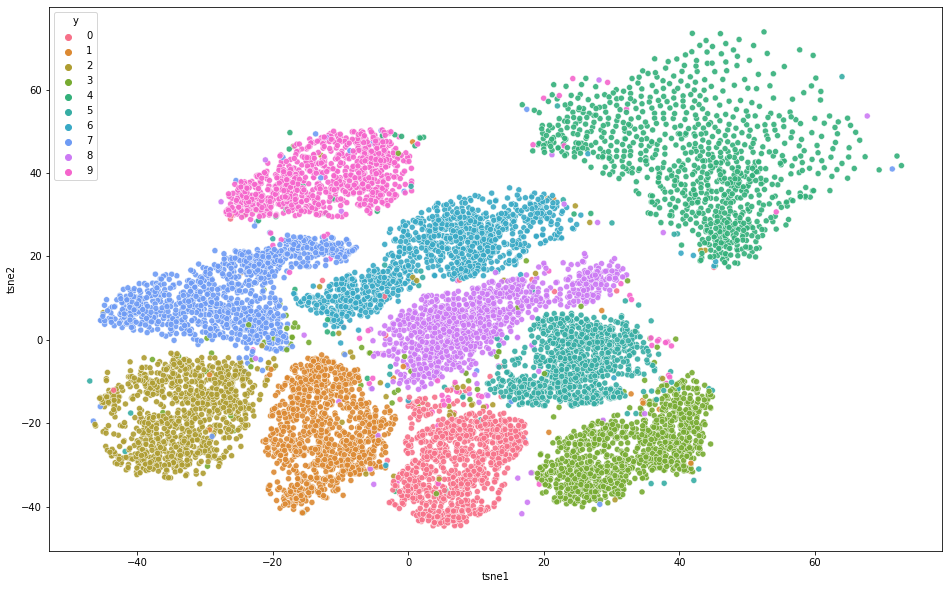

In [63]:



print("DONE")

df_new=pd.DataFrame(TT[:,0],columns=["tsne1"])
df_new["tsne2"]=TT[:,1]
df_new["y"]=ytSNE[0:10000]
print(df_new.head())
plt.figure(figsize=(16,10))   #plot for t-SNE between two components
sns.scatterplot(   x="tsne1", y="tsne2",   hue="y",   palette=sns.color_palette("husl", 10),   data=df_new,   legend="full",   alpha=0.9)
plt.show()

In [133]:
xx.predict_proba(X_test.T)

array([[0.09616563, 0.11744559, 0.09967324, ..., 0.1016172 , 0.10426511,
        0.09536634],
       [0.09616556, 0.11744516, 0.09967351, ..., 0.101617  , 0.10426509,
        0.09536637],
       [0.0961655 , 0.11744546, 0.09967335, ..., 0.10161687, 0.1042651 ,
        0.09536641],
       ...,
       [0.09616539, 0.11744531, 0.09967343, ..., 0.10161697, 0.10426547,
        0.09536631],
       [0.09616562, 0.11744527, 0.09967329, ..., 0.10161707, 0.10426515,
        0.09536637],
       [0.09616534, 0.1174452 , 0.09967336, ..., 0.10161718, 0.10426542,
        0.09536634]])

In [102]:
print(xx.score(X_test.T,y_test))

0.9679047619047619


In [124]:
with open('weight_relu.txt', 'wb') as f:
  pickle.dump(weight_cost_relu, f)
with open('bias_relu.txt', 'wb') as f:
  pickle.dump(bias_relu, f)

In [122]:
with open('weight_linear.txt', 'wb') as f:
  pickle.dump(weight_cost_linear, f)
with open('bias_linear.txt', 'wb') as f:
  pickle.dump(bias_linear, f)


In [115]:
with open('weight_sigmoid.txt', 'wb') as f:
  pickle.dump(weight_cost_sigmoid, f)
with open('bias_sigmoid.txt', 'wb') as f:
  pickle.dump(bias_sigmoid, f)

In [119]:
with open('weight_tanh.txt', 'wb') as f:
  pickle.dump(weight_cost_tanh, f)
with open('bias_tanh.txt', 'wb') as f:
  pickle.dump(bias_tanh, f)




In [92]:
with open('weight_tanh.txt', 'r') as f:
  weight = pickle.load(f)

with open('bias_tanh.txt', 'r') as f:
  bias = pickle.load(f)

In [65]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score


In [103]:
mlp = MLPClassifier(hidden_layer_sizes=(256,128,64), activation='relu', max_iter=100,alpha=0.1,batch_size=100)
mlp.fit(X_train,y_train)
y_pred=mlp.predict(X_test)
accuracy_score(y_pred, y_test)

/usr/local/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:587: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


0.9745714285714285

In [106]:
mlp = MLPClassifier(hidden_layer_sizes=(256,128,64), activation='tanh', max_iter=100, alpha=0.1,batch_size=100)
mlp.fit(X_train,y_train)
y_pred=mlp.predict(X_test)
accuracy_score(y_pred, y_test)

/usr/local/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:587: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


0.9657142857142857

In [107]:
mlp = MLPClassifier(hidden_layer_sizes=(256,128,64), activation='identity', max_iter=100,alpha=0.1,batch_size=100)
mlp.fit(X_train,y_train)
y_pred=mlp.predict(X_test)
accuracy_score(y_pred, y_test)


/usr/local/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:587: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


0.8002857142857143

In [108]:
mlp = MLPClassifier(hidden_layer_sizes=(256,128,64), activation='logistic', max_iter=100,alpha=0.1,batch_size=100)
mlp.fit(X_train,y_train)
y_pred=mlp.predict(X_test)
accuracy_score(y_pred, y_test)

/usr/local/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:587: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


0.9064761904761904

0.9764761904761905